# Detection Methods

This code will consist of multiple methods to attempt to retrieve objects from images.


## Load Data

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
IMAGES_FOLDER = "/home/matthijs/robotics_q3/mav/AE4317_2019_datasets/cyberzoo_aggressive_flight/20190121-144646/"
VIDEO_FILE = "/home/matthijs/robotics_q3/mav/cyberzoo.mp4"
VIDEO_FILE_SIM = "/home/matthijs/paparazzi/videos/vlc-record-2023-03-03-11h21m26s-rtp_5000.sdp-.avi"
SHOW_CV2_IMG = False
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

images_cyberzoo = load_images_from_folder(IMAGES_FOLDER)

In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [3]:
def show_img(img, gray_scale=False, img_name="img"):
    if SHOW_CV2_IMG:
        cv2.imshow(img_name, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        if gray_scale:
            cmap = "gray"
        else:
            cmap = None
        plt.imshow(img, cmap=cmap)



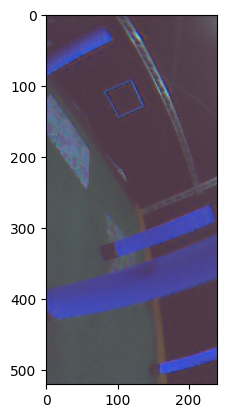

In [4]:
# Example image
example_img = images_cyberzoo[0]
img_name = "cyberzoo_example"
show_img(example_img)

## Edge Detection

### Handcrafted edge-detection

In [5]:
# convert to gray scale
def rgb_2_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray


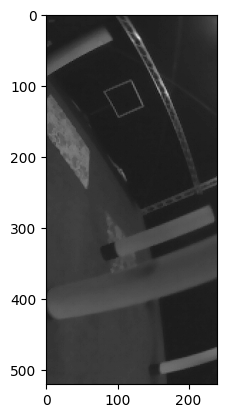

In [6]:
img = images_cyberzoo[0]
gray_img = rgb_2_gray(img)
show_img(gray_img, gray_scale=True)


In [7]:
def edge_detection(filter, image):
    gray_img = rgb_2_gray(image)
    edges_img = np.zeros_like(gray_img)
    N, M = gray_img.shape
    for row in range(3, N-2):
        for col in range(3,M-2):
            local_pixels = gray_img[row-1:row+2, col-1:col+2]
            transformed_pixels = filter * local_pixels
            score = (transformed_pixels.sum() + 4)/8
            edges_img[row,col] = score*3
    return edges_img

def canny_edge_detection(image, th1=100, th2=200):
    edges = cv2.Canny(image, th1, th2)
    return edges

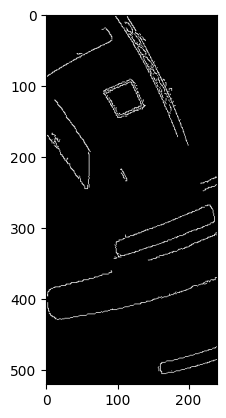

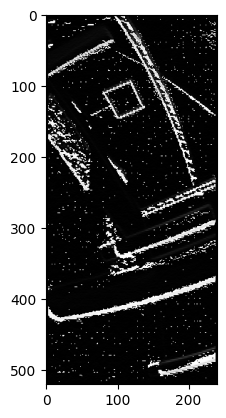

In [8]:
vertical_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
horizontal_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

canny_edges_img = canny_edge_detection(img)
ver_edges_img = edge_detection(vertical_filter,img)
hor_edges_img = edge_detection(horizontal_filter, img)
plt.figure(1)
plt.imshow(canny_edges_img, cmap="gray")
plt.figure(2)
show_img(ver_edges_img, gray_scale=True)

## Corner Detection

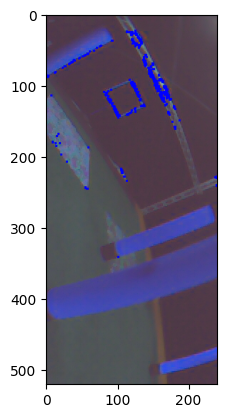

In [9]:
img = images_cyberzoo[0]
gray = rgb_2_gray(img)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
show_img(img)
if cv2.waitKey(0) & 0xff == ord('q'):
    cv2.destroyAllWindows()

Leads to very useless data unfortunately

## SIFT/SURF/ORB

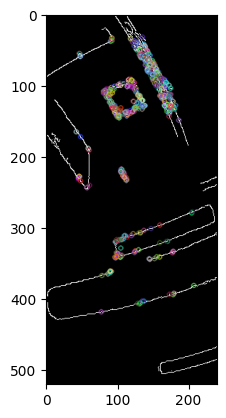

In [10]:
img = canny_edges_img # images_cyberzoo[0]
orb = cv2.ORB_create()
# surf = cv2.xfeatures2d.SURF_create()
keypoints, descriptors = orb.detectAndCompute(img, None)

img = cv2.drawKeypoints(img, keypoints, None)
plt.imshow(img)
if SHOW_CV2_IMG:
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Optical Flow

In [11]:



def smoothen_image(image, size):
    return cv2.blur(image, (size, size))

def optical_flow(cap, first_frame, smoothen=0):
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    # Creates an image filled with zero
    # intensities with the same dimensions 
    # as the frame
    mask = np.zeros_like(first_frame)
    
    # Sets image saturation to maximum
    mask[..., 1] = 255
    
    while(cap.isOpened()):
        
        # ret = a boolean return value from getting
        # the frame, frame = the current frame being
        # projected in the video
        ret, frame = cap.read()
        
        # Opens a new window and displays the input
        # frame
        cv2.imshow("input", frame)
        
        # Converts each frame to grayscale - we previously 
        # only converted the first frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, 
                                        None,
                                        0.5, 3, 45, 3, 5, 1.2, 0)
        
        # Computes the magnitude and angle of the 2D vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        # Sets image hue according to the optical flow 
        # direction
        mask[..., 0] = angle * 180 / np.pi / 2
        
        # Sets image value according to the optical flow
        # magnitude (normalized)
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        
        # Converts HSV to RGB (BGR) color representation
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

        gray_flow_img = rgb_2_gray(rgb)
        if smoothen > 0:
            gray_flow_img = smoothen_image(gray_flow_img, smoothen)
            #gray_flow_img = cv2.GaussianBlur(gray_flow_img, (9, 9),0)
        # Opens a new window and displays the output frame
        cv2.imshow("dense optical flow", gray_flow_img)
        cv2.imshow("dense optical flow", rgb)
        
        # Updates previous frame
        prev_gray = gray
        
        # Frames are read by intervals of 1 millisecond. The
        # programs breaks out of the while loop when the
        # user presses the 'q' key
        if cv2.waitKey(33) & 0xFF == ord('q'):
            break
    
    # The following frees up resources and
    # closes all windows
    cap.release()
    cv2.destroyAllWindows()

In [12]:
cap = cv2.VideoCapture(VIDEO_FILE_SIM)
  
# ret = a boolean return value from
# getting the frame, first_frame = the
# first frame in the entire video sequence
ret, first_frame = cap.read()
optical_flow(cap, first_frame, smoothen=0)

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/matthijs/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [2]:
# This Optical flow implementation yields to way better results
import time



def draw_flow(img, flow, step=16):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr


def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr




cap = cv2.VideoCapture(VIDEO_FILE_SIM)

suc, prev = cap.read()

prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
#prevgray = canny_edge_detection(prevgray)

while True:

    suc, img = cap.read()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = canny_edge_detection(gray)
    # start time to calculate FPS
    start = time.time()


    flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    prevgray = gray


    # End time
    end = time.time()
    # calculate the FPS for current frame detection
    fps = 1 / (end-start)

    print(f"{fps:.2f} FPS")

    cv2.imshow('flow', draw_flow(gray, flow))
    cv2.imshow('flow HSV', draw_hsv(flow))


    key = cv2.waitKey(5)
    if key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


35.62 FPS
42.84 FPS
47.04 FPS


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/matthijs/.local/lib/python3.10/site-packages/cv2/qt/plugins"


45.18 FPS
47.06 FPS
45.00 FPS
47.95 FPS
47.43 FPS
46.07 FPS
48.90 FPS
45.07 FPS
48.31 FPS
48.48 FPS
46.99 FPS
46.91 FPS
46.65 FPS
44.24 FPS
49.11 FPS
48.57 FPS
46.55 FPS
49.02 FPS
43.72 FPS
44.42 FPS
48.25 FPS
46.24 FPS
47.55 FPS
47.52 FPS
47.29 FPS
44.78 FPS
45.43 FPS
48.89 FPS
46.81 FPS
47.49 FPS
46.34 FPS
44.57 FPS
45.35 FPS
47.47 FPS
49.03 FPS
49.20 FPS
45.04 FPS
48.55 FPS
48.83 FPS
49.89 FPS
44.24 FPS
48.79 FPS
47.06 FPS
48.13 FPS
45.42 FPS
48.07 FPS
48.34 FPS
45.16 FPS
48.70 FPS
49.31 FPS
48.89 FPS
48.11 FPS
46.55 FPS
43.73 FPS
46.88 FPS
48.23 FPS
49.06 FPS
45.37 FPS
47.42 FPS
49.32 FPS
47.20 FPS
47.67 FPS
45.79 FPS
44.82 FPS
40.32 FPS
44.80 FPS
46.89 FPS
49.50 FPS
49.15 FPS
48.31 FPS
37.86 FPS
47.96 FPS
47.27 FPS
49.19 FPS
47.00 FPS
45.76 FPS
48.50 FPS
46.66 FPS
49.08 FPS
49.01 FPS
47.67 FPS
45.79 FPS
47.62 FPS
48.88 FPS
48.12 FPS
44.45 FPS
44.98 FPS
46.82 FPS
48.49 FPS
49.13 FPS
48.54 FPS
42.58 FPS
43.11 FPS
44.52 FPS
49.78 FPS
47.60 FPS
49.69 FPS
49.68 FPS
47.60 FPS
49.24 FPS


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


: 

Proposed methods:
  1.  To extract objects from the noisy data: perform DBScan clustering twice. First on the color to get everything that has been appointed a similar color/similar depth with the optical flow and then a second round of clustering is performed on these Clusters. The problem with this approach is that you need to fit the second level clusters for each iteration. So this is not a feasible solution :(

## Background extraction

In [14]:
from __future__ import print_function
import cv2 as cv

# backSub = cv.createBackgroundSubtractorMOG2()

backSub = cv.createBackgroundSubtractorKNN()
capture = cv.VideoCapture(cv.samples.findFileOrKeep(VIDEO_FILE_SIM))
if not capture.isOpened():
    print('Unable to open: ' + VIDEO_FILE_SIM)
    exit(0)
while True:
    ret, frame = capture.read()
    if frame is None:
        break
    
    fgMask = backSub.apply(frame)
    
    
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask', fgMask)
    
    keyboard = cv.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

: 